#Choosing features and metrics for nearest neighbor search

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically

Decide on a notion of similarity
Find the documents that are most similar
In the assignment you will

Gain intuition for different notions of similarity and practice finding similar documents.
Explore the tradeoffs with representing documents using raw word counts and TF-IDF
Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.


In [1]:
import pandas as pd                      # see below for install instruction
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
from scipy.sparse import csr_matrix      # sparse matrices
%matplotlib inline

In [2]:
wiki = pd.read_csv('/Users/April/Downloads/people_wiki.csv')

In [3]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


#Extract word count vectors

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [5]:
word_count = load_sparse_csr('/Users/April/Downloads/people_wiki_word_count.npz')

In [6]:
word_count

<59071x547979 sparse matrix of type '<type 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [7]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 
wiki['text_clean'] = wiki['text'].apply(remove_punctuation)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
word_count_matrix = vectorizer.fit_transform(wiki['text_clean'])

In [9]:
word_count_matrix

<59071x548552 sparse matrix of type '<type 'numpy.int64'>'
	with 10379254 stored elements in Compressed Sparse Row format>

#Find nearest neighbors using word count vectors

In [10]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

In [11]:
print wiki[wiki['name'] == 'Barack Obama']

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  \
35817  barack hussein obama ii brk husen bm born augu...   

                                              text_clean  
35817  barack hussein obama ii brk husen bm born augu...  


In [12]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

In [13]:
distances

array([[  0.        ,  33.07567082,  34.39476704,  36.15245497,
         36.16628264,  36.33180425,  36.40054945,  36.49657518,
         36.63331817,  36.95943723]])

In [14]:
indices

array([[35817, 24478, 28447, 35357, 14754, 13229, 31423, 22745, 36364,
         9210]])

In [15]:
distances.flatten()

array([  0.        ,  33.07567082,  34.39476704,  36.15245497,
        36.16628264,  36.33180425,  36.40054945,  36.49657518,
        36.63331817,  36.95943723])

In [16]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

In [17]:
neighbors['id'].dtype

dtype('int64')

In [18]:
wiki['id'] = wiki.index
print pd.merge(wiki, neighbors, how = 'inner', on='id')[['id','name','distance']].sort('distance', ascending = True)

      id                        name   distance
8  35817                Barack Obama   0.000000
4  24478                   Joe Biden  33.075671
5  28447              George W. Bush  34.394767
7  35357            Lawrence Summers  36.152455
2  14754                 Mitt Romney  36.166283
1  13229            Francisco Barrio  36.331804
6  31423              Walter Mondale  36.400549
3  22745  Wynn Normington Hugh-Jones  36.496575
9  36364                  Don Bonker  36.633318
0   9210                Andy Anstett  36.959437


# Interpreting the nearest neighbors

All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
Andy Anstett is a former politician in Manitoba, Canada.
Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama. To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

First, run the following cell to obtain the word_count column, which represents the word count vectors in the dictionary form. This way, we can quickly recognize words of great importance.

In [19]:
import json
with open('/Users/April/Downloads/people_wiki_map_index_to_word.json', 'r') as f: # Reads the list of most frequent words
    map_index_to_word = json.load(f)

In [20]:
def unpack_dict(matrix, map_index_to_word):
    ##table = list(map_index_to_word.sort('index')['category'])
    # if you're not using SFrame, replace this line with
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in xrange(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [21]:
word_count.shape

(59071, 547979)

In [81]:
wiki.head()

,URI,name,text,text_clean,id,word_count,has_top_words
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,0,"{u'selection': 1, u'carltons': 1, u'being': 1,...",True
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,1,"{u'precise': 1, u'thomas': 1, u'they': 1, u'di...",True
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...,2,"{u'just': 1, u'issued': 1, u'mainly': 1, u'nom...",True
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...,3,"{u'all': 1, u'bauforschung': 1, u'just': 1, u'...",True
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 in tallinn ...,4,"{u'legendary': 1, u'gangstergenka': 1, u'legen...",False


To make things even easier, we provide a utility function that displays a dictionary in tabular form:

In [82]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    for i in row['word_count']:
        word_count_table = pd.DataFrame(i.items(), columns = ['word','count'])
    return word_count_table.sort('count', ascending=False)

obama_words = top_words('Barack Obama')
print obama_words.head()

barrio_words = top_words('Francisco Barrio')
print barrio_words.head()

    word  count
23   the     40
215   in     30
138  and     21
127   of     18
161   to     14
    word  count
220  the     36
84    of     24
206  and     18
184   in     17
125   he     10


(optional) try to figure out a way to convert dict to table using pandas (tried two method from_dict and .items() below)

In [35]:
for i in x['word_count']:
    word_count_table = pd.DataFrame.from_dict(i, orient='index')

In [36]:
word_count_table = word_count_table.reset_index()

In [37]:
word_count_table.rename(columns={'index': 'word', 0: 'count'}, inplace=True)

In [83]:
word_count_table.head()

,word,count
0,just,1
1,issued,1
2,mainly,1
3,nominated,1
4,years,1


In [39]:
for i in x['word_count']:
    word_count_table = pd.DataFrame(i.items(), columns = ['word','count'])

In [84]:
word_count_table.head()

,word,count
0,just,1
1,issued,1
2,mainly,1
3,nominated,1
4,years,1


In [41]:

combined_words = pd.merge(obama_words, barrio_words, how = 'inner', on = 'word')

In [42]:
combined_words.rename(columns = {'count_x': 'Obama', 'count_y': 'Barrio'}, inplace=True)

In [85]:
combined_words.head()

,word,Obama,Barrio
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9


In [86]:
combined_words.sort('Obama', ascending=False).head()

,word,Obama,Barrio
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9


In [45]:
common_words = set([m for m in combined_words[0:5]['word']])

In [46]:
print common_words
    

set([u'and', u'of', u'the', u'to', u'in'])


In [47]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set([k for k,v in word_count_vector.items()])   
    # return True if common_words is a subset of unique_words
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)



In [48]:
sum(wiki['has_top_words'] == True)

56066

In [50]:
print 'Output from your function:', has_top_words(wiki.iloc[32]['word_count'])

Output from your function: True


In [53]:
len(set([k for k,v in wiki.iloc[32]['word_count'].items()]))

167

In [54]:
print 'Output from your function:', has_top_words(wiki.iloc[33]['word_count'])

Output from your function: False


Quiz Question. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [55]:
from sklearn.metrics.pairwise import euclidean_distances

In [59]:
obama_matrix = wiki[wiki['name'] == 'Barack Obama']['word_count']
bush_matrix = wiki[wiki['name'] == 'George W. Bush']['word_count']
joe_matrix = wiki[wiki['name'] == 'Joe Biden']['word_count']

In [73]:
o = int(wiki[wiki['name'] == 'Barack Obama']['id'])
b = int(wiki[wiki['name'] == 'George W. Bush']['id'])
j = int(wiki[wiki['name'] == 'Joe Biden']['id'])

In [66]:
bush_matrix.index

Int64Index([28447], dtype='int64')

In [67]:
joe_matrix.index

Int64Index([24478], dtype='int64')

In [74]:
o_b = euclidean_distances(word_count[o], word_count[b])
o_j = euclidean_distances(word_count[o], word_count[j])
b_j = euclidean_distances(word_count[b], word_count[j])

In [76]:
print "euclidean_distances for obama and bush is: ", o_b
print "euclidean_distances for obama and joe is: ", o_j
print "euclidean_distances for bush and joe is: ", b_j

euclidean_distances for obama and bush is:  [[ 34.39476704]]
euclidean_distances for obama and joe is:  [[ 33.07567082]]
euclidean_distances for bush and joe is:  [[ 32.75667871]]


In [ ]:
obama_words = top_words('Barack Obama')
bush_words = top_words('George W. Bush')

In [77]:
ob_combined_words = pd.merge(obama_words, bush_words, how='inner', on = 'word')

In [80]:
ob_combined_words.sort('count_x', ascending=False)[0:10]

,word,count_x,count_y
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
5,his,11,6
6,act,8,3
7,he,7,8
8,a,7,6
9,as,6,6


#Extract the TF-IDF vectors

In [87]:
tf_idf = load_sparse_csr('/Users/April/Downloads/people_wiki_tf_idf.npz')

In [96]:
tf_idf

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [130]:
tf_idf.data

array([  1.09864954e+01,   1.09864954e+01,   1.09864954e+01, ...,
         5.79243810e-03,   6.70629508e-03,   1.42208980e-03])

In [88]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [89]:
corpus = [i for i in wiki['text_clean']]

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', min_df = 0, stop_words = 'english')

In [121]:
tfidf_matrix =  tf.fit_transform(corpus)
feature_names = tf.get_feature_names() 

In [122]:
len(feature_names)

548203

In [123]:
tfidf_matrix

<59071x548203 sparse matrix of type '<type 'numpy.float64'>'
	with 8078399 stored elements in Compressed Sparse Row format>

In [124]:
len(feature_names)

548203

##Find nearest neighbors using TF-IDF vectors

In [108]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

In [151]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=20)

In [152]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
wiki['id'] = wiki.index
print pd.merge(wiki, neighbors, how = 'inner', on='id')[['id','name','distance']].sort('distance', ascending = True)

       id                     name    distance
6   35817             Barack Obama    0.000000
2    7914            Phil Schiliro  106.861014
16  46811            Jeff Sessions  108.871674
14  44681   Jesse Lee (politician)  109.045698
7   38376           Samantha Power  109.108106
0    6507             Bob Menendez  109.781867
9   38714  Eric Stern (politician)  109.957788
15  44825           James A. Guest  110.413889
13  44368     Roland Grossenbacher  110.470609
5   33417            Tulsi Gabbard  110.696998
17  49944            Howard Dawson  110.730547
3    7950         Elizabeth Warren  111.039450
1    6796              Eric Holder  111.061971
8   38495             Barney Frank  111.102213
11  42859       John S. Martin Jr.  111.219609
18  52242               Tom Harkin  111.220666
10  40099            Harry Arthurs  111.287834
4   18125        Stanley S. Harris  111.338901
19  56008            Nathan Cullen  111.442101
12  44227  Robert Price (attorney)  111.457553


In [117]:
model_tf_idf_test = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf_test.fit(tfidf_matrix)
distances_test, indices_test = model_tf_idf_test.kneighbors(tfidf_matrix[35817], n_neighbors=10)
neighbors_test = pd.DataFrame({'distance':distances_test.flatten(), 'id':indices_test.flatten()})

In [143]:
feature_names[2000]

u'1155lones'

In [132]:
tf_idf[35817]

<1x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 273 stored elements in Compressed Sparse Row format>

In [134]:
tfidf_matrix[35817]

<1x548203 sparse matrix of type '<type 'numpy.float64'>'
	with 229 stored elements in Compressed Sparse Row format>

In [135]:
len(wiki)

59071

In [147]:
'and' in feature_names

False

In [148]:
neighbors_test

,distance,id
0,0.000000,35817
1,1.165145,24478
2,1.207371,38376
3,1.219641,57108
4,1.222510,38714
5,1.236179,46140
6,1.243057,18827
7,1.244668,44681
8,1.248297,6796
9,1.251608,2412


In [215]:
print pd.merge(wiki, neighbors_test, how = 'inner', on='id')[['id','name','distance']].sort('distance', ascending = True)

      id                     name  distance
4  35817             Barack Obama  0.000000
3  24478                Joe Biden  1.165145
5  38376           Samantha Power  1.207371
9  57108   Hillary Rodham Clinton  1.219641
6  38714  Eric Stern (politician)  1.222510
8  46140             Robert Gibbs  1.236179
2  18827             Henry Waxman  1.243057
7  44681   Jesse Lee (politician)  1.244668
1   6796              Eric Holder  1.248297
0   2412          Joe the Plumber  1.251608


In [154]:
wiki.iloc[57108]

URI              <http://dbpedia.org/resource/Hillary_Rodham_Cl...
name                                        Hillary Rodham Clinton
text             hillary diane rodham clinton hlri dan rdm klnt...
text_clean       hillary diane rodham clinton hlri dan rdm klnt...
id                                                           57108
word_count       {u'serving': 1, u'office': 1, u'diplomacy': 1,...
has_top_words                                                 True
tf_idf           {u'serving': 2.84705486735, u'office': 2.62408...
tf_idf_test      {u'serving': 2.84705486735, u'office': 2.62408...
Name: 57108, dtype: object

In [156]:

def top_words_tf_idf(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    for i in row['tf_idf']:
        word_count_table = pd.DataFrame(i.items(), columns = ['word','weight'])
    return word_count_table.sort('weight', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print obama_tf_idf.head()

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
print schiliro_tf_idf.head()

        word     weight
189    obama  43.295653
133      act  27.678223
157     iraq  17.747379
208  control  14.887061
99       law  14.722936
                word     weight
16          schiliro  21.972991
8              staff  15.856442
87     congressional  13.547088
104  daschleschiliro  10.986495
83             obama   9.621256


In [157]:
wiki.head()

,URI,name,text,text_clean,id,word_count,has_top_words,tf_idf,tf_idf_test
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,0,"{u'selection': 1, u'carltons': 1, u'being': 1,...",True,"{u'selection': 3.83657855309, u'carltons': 7.0...","{u'selection': 3.83657855309, u'carltons': 7.0..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,1,"{u'precise': 1, u'thomas': 1, u'they': 1, u'di...",True,"{u'precise': 6.44320060696, u'thomas': 3.32027...","{u'precise': 6.44320060696, u'thomas': 3.32027..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...,2,"{u'just': 1, u'issued': 1, u'mainly': 1, u'nom...",True,"{u'just': 2.70072996871, u'issued': 4.42971703...","{u'just': 2.70072996871, u'issued': 4.42971703..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...,3,"{u'all': 1, u'bauforschung': 1, u'just': 1, u'...",True,"{u'all': 1.64311124349, u'bauforschung': 10.98...","{u'all': 1.64311124349, u'bauforschung': 10.98..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 in tallinn ...,4,"{u'legendary': 1, u'gangstergenka': 1, u'legen...",False,"{u'legendary': 4.28085629437, u'gangstergenka'...","{u'legendary': 4.28085629437, u'gangstergenka'..."


In [158]:

combined_words_tfidf = pd.merge(obama_tf_idf, schiliro_tf_idf, how = 'inner', on = 'word')

In [163]:
combined_words_tfidf.sort('weight_x', ascending=False)[0:10]

,word,weight_x,weight_y
0,obama,43.295653,9.621256
1,law,14.722936,7.361468
2,democratic,12.410689,6.205344
3,senate,10.164288,3.388096
4,presidential,7.386955,3.693478
5,president,7.226869,9.033587
6,policy,6.095386,3.047693
7,states,5.473201,1.824400
8,office,5.248173,2.624086
9,2011,5.107041,3.404694


In [164]:
common_words = set([m for m in combined_words_tfidf[0:5]['word']])  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set([k for k,v in word_count_vector.items()])   
    # return True if common_words is a subset of unique_words
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)


In [165]:
sum(wiki['has_top_words'])

14

#Choosing metrics

In [242]:
# Comptue length of all documents
def compute_length(row):
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length, axis=1) #put axis = 1 means apply to each row

# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = pd.merge(wiki, neighbors, on = 'id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_euclidean.head()

       id                    name  length    distance
58  35817            Barack Obama     540    0.000000
18   7914           Phil Schiliro     208  106.861014
79  46811           Jeff Sessions     230  108.871674
76  44681  Jesse Lee (politician)     216  109.045698
63  38376          Samantha Power     310  109.108106


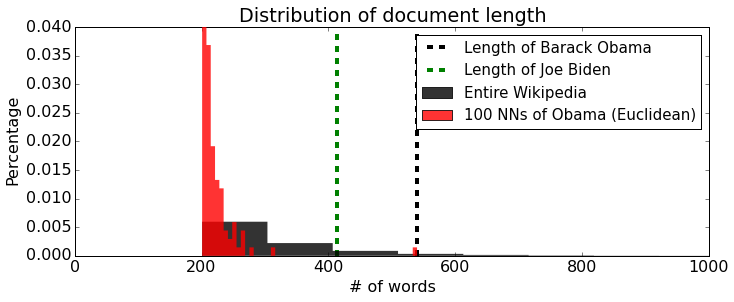

In [213]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Barack Obama']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)  # convert series to integer
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Joe Biden']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)   # convert series to integer
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

To remove this bias, we turn to cosine distances: $$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$ Cosine distances let us compare word distributions of two articles of varying lengths.
Let us train a new nearest neighbor model, this time with cosine distances. We then repeat the search for Obama's 100 nearest neighbors.

In [243]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = pd.merge(wiki,neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_cosine.head()

       id                     name  length      distance
59  35817             Barack Obama     540 -1.110223e-15
45  24478                Joe Biden     414  7.031387e-01
65  38376           Samantha Power     310  7.429819e-01
98  57108   Hillary Rodham Clinton     580  7.583584e-01
67  38714  Eric Stern (politician)     255  7.705612e-01


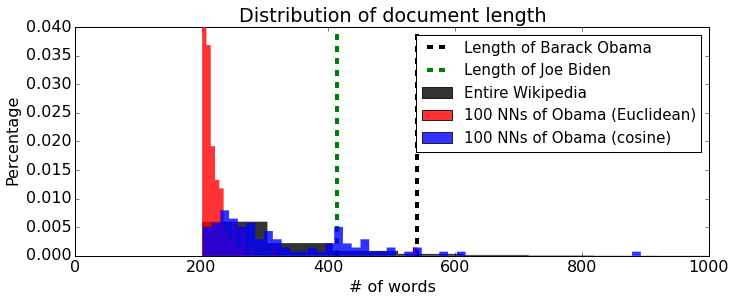

In [218]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Barack Obama']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Joe Biden']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

##Problem with cosine distances: tweets vs. long articles

In [219]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [237]:
word_indices = [map_index_to_word[word] for word in tweet.keys()]
tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )

In [240]:
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = tf_idf[35817]
print cosine_distances(obama_tf_idf, tweet_tf_idf)

[[ 0.70591838]]


In [241]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)
print distances

[[ -1.11022302e-15   7.03138677e-01   7.42981902e-01   7.58358398e-01
    7.70561228e-01   7.84677505e-01   7.88039073e-01   7.90926415e-01
    7.98322603e-01   7.99466360e-01]]
